In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

Using Theano backend.
C:\Users\faisal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
importlib.reload(gr)

<module 'graph' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\graph.py'>

In [3]:
domain = ['apnea','obesity']
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
datapath='C:/Users/faisal/PycharmProjects/linkPrediction/dataframes'
modelpath='C:/Users/faisal/PycharmProjects/linkPrediction/models'
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
time=[1990,1991,1996,1,1,20]
df, key_list = ut.load_dataset(filepath, column_split)

In [ ]:
#dynamic train graphs and test graph build and save in disk 
importlib.reload(gr)
time=[2005,2006,2015,1,1,20]
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

259
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1983.gpickle saved, nodes: 3 edges: 1
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1984.gpickle saved, nodes: 9 edges: 4
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1985.gpickle saved, nodes: 6 edges: 1
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1986.gpickle saved, nodes: 10 edges: 1
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1987.gpickle saved, nodes: 8 edges: 4
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1988.gpickle saved, nodes: 11 edges: 9
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1989.gpickle saved, nodes: 16 edges: 10
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1990.gpickle saved, nodes: 21 edges: 4
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1991.gpickle saved, nodes: 31 edges: 27
C:/Users/faisal/PycharmProjects/linkPrediction/graphs

In [4]:
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2005.gpickle loaded, nodes: 70 edges: 47
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2006.gpickle loaded, nodes: 79 edges: 56
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2007.gpickle loaded, nodes: 400 edges: 699
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
C:/Users/faisal/Pycha

In [5]:
importlib.reload(fs)
importlib.reload(cl)

freq=10
#time=[2001,2007,2015,1,1,10]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1310 neg in time series: 11188 pos-neg ratio: 0.11708973900607794 total: 12498


In [249]:
ts = time[1]
te = time[2]
row = node_feature[ts].columns.values.tolist()
feature_names = row[1:len(row)]
feature = ['degree']
columns_drop = list(set(feature_names).difference(set(feature)))
pruned_data = copy.deepcopy(node_feature)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)

In [250]:
node_list = set(g_train_static.nodes()).intersection(g_test_static.nodes())
node_list = list(node_list)

In [251]:
ts = time[1]
te = time[2]
it_index = time[4]
time_range = te - ts
total_sample = len(node_list)
feature_length = len(pruned_data[ts].iloc[1]) - 1
X = np.zeros([total_sample, time_range, feature_length])
y = np.zeros(total_sample)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (327, 9, 1) y shape: (327,)


In [252]:
for id, edge in enumerate(node_list):
    for t in range(ts, te, it_index):
        if edge in set(pruned_data[t]['node_index']):
            sample_row = np.asarray(pruned_data[t].loc[pruned_data[t]['node_index'] == edge].values[0])
            X[id][t - ts] = sample_row[1:feature_length + 1]
            y[id] = len(g_test_static[edge])

In [261]:
# s_nodes = [12542,16381,6451,3392,6539,14408,15920,12700]
# s_index = []
# X_test = np.zeros([len(s_nodes), time_range, feature_length])
# y_test = np.zeros(len(s_nodes))
# for i,nd in enumerate(s_nodes):
#     X_test[i] = X[node_list.index(nd)]
#     y_test[i] = y[node_list.index(nd)] 
#     s_index.append(node_list.index(nd))
# X_train = np.delete(X, s_index, axis =0)
# y_train = np.delete(y, s_index, axis =0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [267]:
input_length = X.shape[1]
input_dim = X.shape[2]
output_dim = 1
batch_size = 64
epoch =  40
model = Sequential()
model.add(LSTM(10, input_shape=(input_length, input_dim),return_sequences=True))
model.add(LSTM(20))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
# model.add(Dense(20, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse',
                  optimizer='Adam',
                  metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    shuffle=True,
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=1)

Train on 261 samples, validate on 66 samples
Epoch 1/40
261/261 [==============================] - 0s 186us/step - loss: 41.8017 - acc: 0.1264 - val_loss: 20.6440 - val_acc: 0.1212
Epoch 2/40
261/261 [==============================] - 0s 202us/step - loss: 41.2588 - acc: 0.1264 - val_loss: 20.2148 - val_acc: 0.1212
Epoch 3/40
261/261 [==============================] - 0s 173us/step - loss: 40.7303 - acc: 0.1264 - val_loss: 19.8064 - val_acc: 0.1212
Epoch 4/40
261/261 [==============================] - 0s 174us/step - loss: 40.2101 - acc: 0.1264 - val_loss: 19.4124 - val_acc: 0.1212
Epoch 5/40
261/261 [==============================] - 0s 298us/step - loss: 39.7607 - acc: 0.1264 - val_loss: 18.9928 - val_acc: 0.1212
Epoch 6/40
261/261 [==============================] - 0s 395us/step - loss: 39.2068 - acc: 0.1264 - val_loss: 18.5293 - val_acc: 0.1212
Epoch 7/40
261/261 [==============================] - 0s 312us/step - loss: 38.5937 - acc: 0.1264 - val_loss: 17.9585 - val_acc: 0.1061
Epo

In [268]:
s_nodes = [12542,16381,6451,3392,6539,14408,15920,12700]
s_index = []
X_test = np.zeros([len(s_nodes), time_range, feature_length])
y_test = np.zeros(len(s_nodes))
for i,nd in enumerate(s_nodes):
    X_test[i] = X[node_list.index(nd)]
    y_test[i] = y[node_list.index(nd)] 
    s_index.append(node_list.index(nd))
y_pred = model.predict(X_test)

In [269]:
print(y_pred, y_test)

[[7.8835864]
 [7.882037 ]
 [7.790471 ]
 [7.8580966]
 [7.802829 ]
 [7.8422804]
 [7.6899853]
 [7.7237334]] [51. 51.  4. 20. 12.  8. 18. 23.]


In [6]:
t = 1981
nodes = set(key_list['id'])
g = nx.Graph()
static_graph = gr.build_graph(g, df, key_list, nodes, 1980, 2017)

In [10]:
file_name = os.path.join(graphpath, "all_year_apnea" + ".gpickle")
gr.save_graph(static_graph, file_name)

In [5]:
file_name = os.path.join(graphpath, "all_year_apnea" + ".gpickle")
static_graph = gr.load_graph(file_name)

In [10]:
dyn_graph = {}
nodes = set(key_list['id'])
for t in range(1981,2017):
    g = nx.Graph()
    dyn_graph[t] = gr.build_graph(g, df, key_list, nodes, t, t+1)

In [9]:
dyn_graph = {}
nodes = set(key_list['id'])
# for t in range(1981,2017):
#     file_name = os.path.join(graphpath, "single_year_apnea"+str(t) +".gpickle")
#     gr.save_graph(dyn_graph[t], file_name)
    
for t in range(1981,2017):
    file_name = os.path.join(graphpath, "single_year_apnea"+str(t) +".gpickle")
    dyn_graph[t] = gr.load_graph(file_name)

In [64]:
s_nodes = [12542,16381,6451]
first = []
second = []
third = []
for t in range(1982,2016):
    degrees = list(dyn_graph[t].degree(s_nodes))
    #print(degrees,len(degrees))
    first.append(degrees[0][1])
    if len(degrees)==1:
        second.append(0)
        third.append(0)
    elif len(degrees)==2:
        third.append(0)
        second.append(degrees[1][1])
    else:
        second.append(degrees[1][1])
        third.append(degrees[2][1])
#     first.append()
#first = third

In [65]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
series = Series(first)
#print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
#print(normalized)
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
#print(inversed)

# d_set = []
# for i in range(0,len(first)-3):
#     print(first[i:i+3],first[i+3])
#     d_set.append([first[i:i+3],first[i+3]])

Min: 0.000000, Max: 136.000000


C:\Users\faisal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [66]:
first = normalized.flatten().tolist()
d_set = []
for i in range(0,len(first)-4):
    print(first[i:i+4],first[i+4], 1982+i+4,i)
    d_set.append([first[i:i+4],first[i+4]])

[0.0661764705882353, 0.029411764705882353, 0.014705882352941176, 0.0] 0.029411764705882353 1986 0
[0.029411764705882353, 0.014705882352941176, 0.0, 0.029411764705882353] 0.0 1987 1
[0.014705882352941176, 0.0, 0.029411764705882353, 0.0] 0.03676470588235294 1988 2
[0.0, 0.029411764705882353, 0.0, 0.03676470588235294] 0.051470588235294115 1989 3
[0.029411764705882353, 0.0, 0.03676470588235294, 0.051470588235294115] 0.058823529411764705 1990 4
[0.0, 0.03676470588235294, 0.051470588235294115, 0.058823529411764705] 0.2647058823529412 1991 5
[0.03676470588235294, 0.051470588235294115, 0.058823529411764705, 0.2647058823529412] 0.13970588235294118 1992 6
[0.051470588235294115, 0.058823529411764705, 0.2647058823529412, 0.13970588235294118] 0.1323529411764706 1993 7
[0.058823529411764705, 0.2647058823529412, 0.13970588235294118, 0.1323529411764706] 0.20588235294117646 1994 8
[0.2647058823529412, 0.13970588235294118, 0.1323529411764706, 0.20588235294117646] 0.3529411764705882 1995 9
[0.13970588235

In [67]:
total_sample = len(d_set)
time_range = len(d_set[0][0])
feature_length = 1
X = np.zeros([total_sample, time_range, feature_length])
y = np.zeros(total_sample)

In [68]:
for i,row in enumerate(d_set):
    for j,row1 in enumerate(row[0]):
        X[i][j]=np.asarray(row1)
    y[i]=row[1]

In [69]:
X_train = X[0:18]
y_train = y[0:18]
X_test = X[18:]
y_test = y[18:]
input_length = X.shape[1]
input_dim = X.shape[2]
output_dim = 1
batch_size = 16
epoch =  500
model = Sequential()
model.add(LSTM(20, input_shape=(input_length, input_dim),return_sequences=True))
model.add(LSTM(40))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(20, activation='sigmoid'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',
                  optimizer='Adam',
                  metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=1)

Epoch 1/500
18/18 [==============================] - 0s 2ms/step - loss: 0.1573 - acc: 0.0000e+00
Epoch 2/500
18/18 [==============================] - 0s 1ms/step - loss: 0.1401 - acc: 0.0000e+00
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 0.1252 - acc: 0.0000e+00
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 0.1114 - acc: 0.0000e+00
Epoch 5/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0991 - acc: 0.0000e+00
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0879 - acc: 0.0556
Epoch 7/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0785 - acc: 0.0556
Epoch 8/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0707 - acc: 0.0556
Epoch 9/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0635 - acc: 0.0556
Epoch 10/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0580 - acc: 0.0556
Epoch 11/500
18/18 [===================

18/18 [==============================] - 0s 3ms/step - loss: 0.0092 - acc: 0.0556
Epoch 86/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.0556
Epoch 87/500
18/18 [==============================] - 0s 9ms/step - loss: 0.0088 - acc: 0.0556
Epoch 88/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0085 - acc: 0.0556
Epoch 89/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0079 - acc: 0.0556
Epoch 90/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0093 - acc: 0.0556
Epoch 91/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0074 - acc: 0.0556
Epoch 92/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0067 - acc: 0.0556
Epoch 93/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0084 - acc: 0.0556
Epoch 94/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0095 - acc: 0.0556
Epoch 95/500
18/18 [==============================] - 0s 5ms/st

18/18 [==============================] - 0s 3ms/step - loss: 0.0088 - acc: 0.0556
Epoch 169/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0094 - acc: 0.0556
Epoch 170/500
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - acc: 0.0556
Epoch 171/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0085 - acc: 0.0556
Epoch 172/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0084 - acc: 0.0556
Epoch 173/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0089 - acc: 0.0556
Epoch 174/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0076 - acc: 0.0556
Epoch 175/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0106 - acc: 0.0556
Epoch 176/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0088 - acc: 0.0556
Epoch 177/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0094 - acc: 0.0556
Epoch 178/500
18/18 [==============================] -

18/18 [==============================] - 0s 2ms/step - loss: 0.0103 - acc: 0.0556
Epoch 253/500
18/18 [==============================] - ETA: 0s - loss: 0.0099 - acc: 0.062 - 0s 2ms/step - loss: 0.0089 - acc: 0.0556
Epoch 254/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0086 - acc: 0.0556
Epoch 255/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0078 - acc: 0.0556
Epoch 256/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0088 - acc: 0.0556
Epoch 257/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0089 - acc: 0.0556
Epoch 258/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0083 - acc: 0.0556
Epoch 259/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0085 - acc: 0.0556
Epoch 260/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0081 - acc: 0.0556
Epoch 261/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0088 - acc: 0.0556
Epoch 262/500
18

18/18 [==============================] - 0s 2ms/step - loss: 0.0080 - acc: 0.0556
Epoch 336/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0095 - acc: 0.0556
Epoch 337/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0083 - acc: 0.0556
Epoch 338/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.0556
Epoch 339/500
18/18 [==============================] - 0s 4ms/step - loss: 0.0102 - acc: 0.0556
Epoch 340/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0085 - acc: 0.0556
Epoch 341/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0074 - acc: 0.0556
Epoch 342/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0074 - acc: 0.0556
Epoch 343/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0092 - acc: 0.0556
Epoch 344/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0099 - acc: 0.0556
Epoch 345/500
18/18 [==============================] -

18/18 [==============================] - 0s 5ms/step - loss: 0.0072 - acc: 0.0556
Epoch 421/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0088 - acc: 0.0556
Epoch 422/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0087 - acc: 0.0556
Epoch 423/500
18/18 [==============================] - 0s 8ms/step - loss: 0.0088 - acc: 0.0556
Epoch 424/500
18/18 [==============================] - ETA: 0s - loss: 0.0094 - acc: 0.0000e+0 - 0s 1ms/step - loss: 0.0085 - acc: 0.0556
Epoch 425/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0085 - acc: 0.0556
Epoch 426/500
18/18 [==============================] - ETA: 0s - loss: 0.0104 - acc: 0.062 - 0s 2ms/step - loss: 0.0094 - acc: 0.0556
Epoch 427/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0082 - acc: 0.0556
Epoch 428/500
18/18 [==============================] - 0s 3ms/step - loss: 0.0086 - acc: 0.0556
Epoch 429/500
18/18 [==============================] - ETA: 0s - loss:

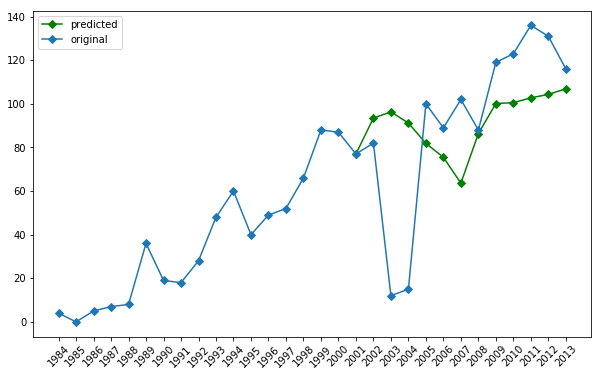

In [70]:
y_pred = model.predict(X_test)
y_pred=y_pred.reshape(len(y_pred))
y_pred=np.concatenate([[y_train[17]],y_pred])
y_pred = y_pred.reshape(len(y_pred),1)
inversed = scaler.inverse_transform(y_pred)
yr = y.reshape(len(y),1)
yr = scaler.inverse_transform(yr)
plt.figure(figsize=(10,6))
plt.plot(range(17,len(yr)),inversed,'-gD',label='predicted')
plt.plot(yr,'-D',label='original')
plt.xticks(range(len(yr)),years,rotation=45)
plt.legend(loc='best')
plt.show()

In [114]:
years=[]
for t in range(1982,2016):
    years.append(t)

In [423]:
[y_train[19]]

[0.5661764705882353]

In [405]:
y_pred = model.predict(X_test)

In [139]:
one1 = np.array([[ 77.        ],
       [ 76.73333788],
       [ 80.90588284],
       [ 16.00479591],
       [ 18.99006975],
       [ 95.17047548],
       [ 86.59634399],
       [ 96.6800909 ],
       [ 85.79441071],
       [108.88802719],
       [111.59759998],
       [119.97759533],
       [116.83127499]])
two1 =  np.array([[77.        ],
       [77.41439104],
       [77.69845772],
       [50.22486591],
       [16.57097363],
       [65.18582845],
       [83.11932182],
       [86.76958227],
       [82.90981627],
       [92.56570005],
       [93.90180159],
       [97.22981501],
       [94.71073866]])
three1 = np.array([[ 77.        ],
       [ 82.33239317],
       [ 81.18750954],
       [ 64.5091486 ],
       [ 46.13602591],
       [ 45.45428371],
       [ 72.18382072],
       [ 89.71016645],
       [ 87.53064394],
       [ 93.08853579],
       [ 96.65682602],
       [102.7322278 ],
       [103.68136215]])
four1 = np.array([[ 77.        ],
       [ 93.49341774],
       [ 96.29041624],
       [ 91.21287537],
       [ 81.88414288],
       [ 75.47765017],
       [ 63.61329246],
       [ 86.37011528],
       [100.15290594],
       [100.55255127],
       [102.7552495 ],
       [104.32537794],
       [106.91454887]])
original1 = np. array([[  9.],
       [  4.],
       [  2.],
       [  0.],
       [  4.],
       [  0.],
       [  5.],
       [  7.],
       [  8.],
       [ 36.],
       [ 19.],
       [ 18.],
       [ 28.],
       [ 48.],
       [ 60.],
       [ 40.],
       [ 49.],
       [ 52.],
       [ 66.],
       [ 88.],
       [ 87.],
       [ 77.],
       [ 82.],
       [ 12.],
       [ 15.],
       [100.],
       [ 89.],
       [102.],
       [ 88.],
       [119.],
       [123.],
       [136.],
       [131.],
       [116.]])

one2 = np.array([[61.        ],
       [55.93930411],
       [49.97134387],
       [ 6.88920742],
       [ 1.66854101],
       [58.76238167],
       [60.13392484],
       [60.13392484],
       [49.19515991],
       [60.80974174],
       [58.06662977],
       [71.86828589],
       [67.20810652]])
two2 =  np.array([[61.        ],
       [57.75900316],
       [54.66317117],
       [31.13255519],
       [ 6.65933582],
       [61.49472392],
       [59.7599473 ],
       [59.61145222],
       [54.25540304],
       [61.10233378],
       [58.52056777],
       [66.10858476],
       [60.94923043]])
three2 = np.array([[61.        ],
       [54.47258139],
       [53.49462271],
       [44.16426826],
       [31.86774653],
       [38.20856941],
       [55.55786312],
       [56.07304657],
       [53.80748296],
       [56.02536452],
       [55.08895206],
       [59.09504366],
       [57.44656324]])
four2 = np.array([[61.        ],
       [68.17871451],
       [65.02494335],
       [63.83976614],
       [53.56674552],
       [40.42928821],
       [28.46245795],
       [47.43586564],
       [71.05775261],
       [70.82363284],
       [69.4513669 ],
       [68.83524227],
       [75.01183069]])
original2 = [2,
 0,
 0,
 2,
 0,
 1,
 7,
 6,
 6,
 17,
 10,
 3,
 23,
 37,
 49,
 29,
 28,
 35,
 66,
 52,
 62,
 61,
 53,
 6,
 1,
 65,
 67,
 67,
 52,
 68,
 64,
 86,
 78,
 70]

one3 = np.array([[16.        ],
       [13.6683327 ],
       [12.74488699],
       [ 6.2904743 ],
       [ 7.20802271],
       [23.64827931],
       [30.48961461],
       [22.31775486],
       [30.07636702],
       [34.11066222],
       [30.90074241],
       [35.27652478],
       [36.04185033]])
two3 =  np.array([[16.        ],
       [11.5182125 ],
       [12.75190598],
       [ 7.00222677],
       [ 7.75833148],
       [26.56737995],
       [25.94132149],
       [13.0509631 ],
       [26.56731915],
       [23.71924531],
       [16.50870866],
       [24.05189264],
       [19.71652591]])
three3 = np.array([[16.        ],
       [26.4355098 ],
       [23.96699405],
       [17.21298313],
       [13.98633003],
       [11.05864388],
       [19.25984716],
       [31.8093456 ],
       [34.34761143],
       [31.98261023],
       [37.05357695],
       [38.74025679],
       [38.14462304]])
four3 = np.array([[16.        ],
       [18.85704041],
       [22.70580626],
       [19.8158536 ],
       [13.90348434],
       [12.76835859],
       [14.26921523],
       [21.12286186],
       [27.37482953],
       [28.54270649],
       [27.88518369],
       [29.8680855 ],
       [30.48581481]]) 
original3 = [0,
 0,
 0,
 0,
 0,
 0,
 7,
 6,
 9,
 6,
 11,
 1,
 9,
 40,
 21,
 8,
 20,
 11,
 6,
 32,
 32,
 16,
 14,
 0,
 2,
 38,
 54,
 35,
 53,
 63,
 55,
 66,
 68,
 55]

In [94]:
# first1=np.asarray(first)
# scaler.inverse_transform(first1.reshape(len(first),1))


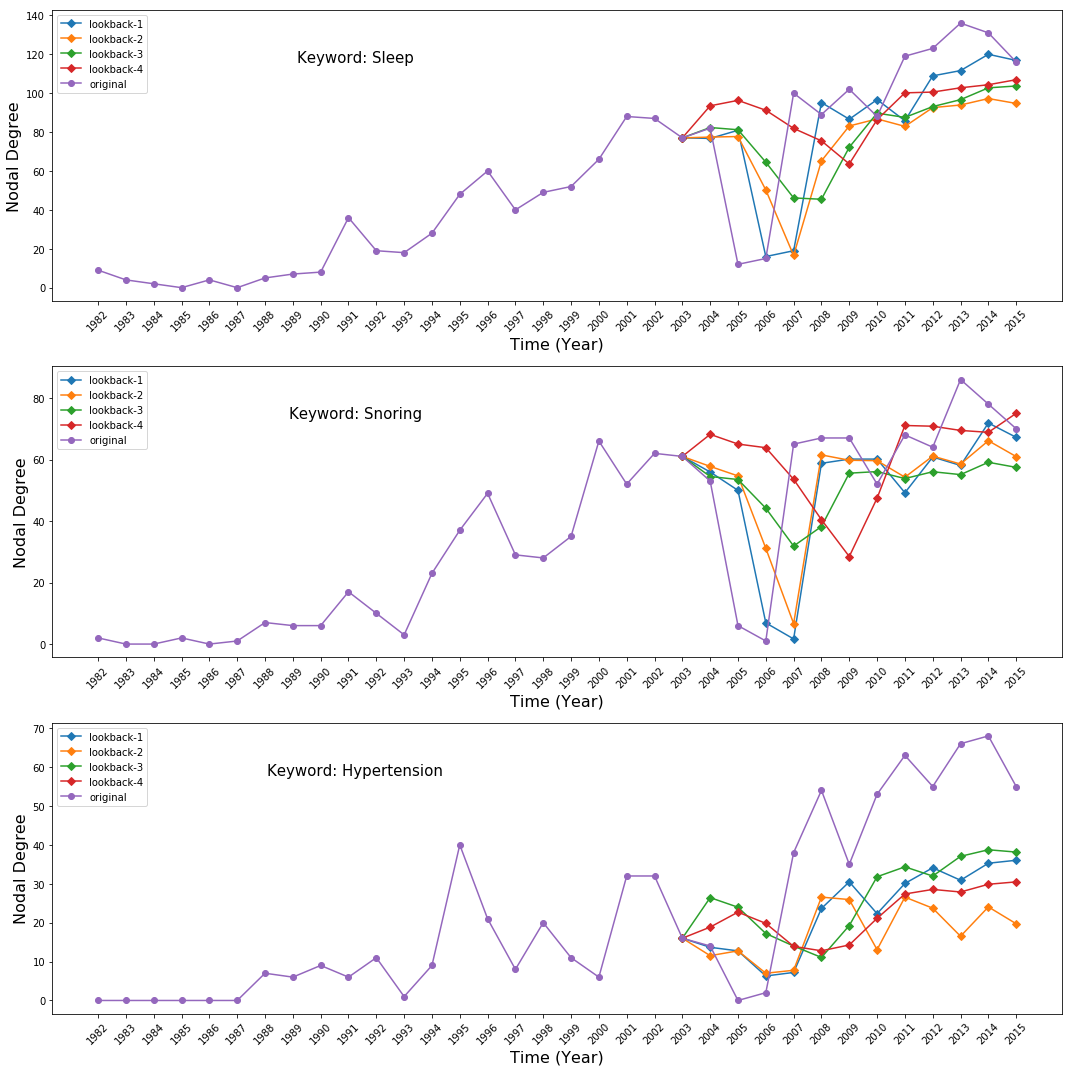

In [152]:
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(range(21,len(original1)),one1,'-D',label='lookback-1')
plt.plot(range(21,len(original1)),two1,'-D',label='lookback-2')
plt.plot(range(21,len(original1)),three1,'-D',label='lookback-3')
plt.plot(range(21,len(original1)),four1,'-D',label='lookback-4')
plt.plot(original1,'-o',label='original')
plt.xticks(range(0,len(years)),years,rotation=45)
plt.legend(loc='best')
#plt.suptitle('Keyword: Sleep', fontsize=20)
plt.title("Keyword: Sleep", position=(0.3, 0.8),fontsize=15)
plt.xlabel('Time (Year)', fontsize=16)
plt.ylabel('Nodal Degree', fontsize=16)
#--------------------------2
plt.subplot(3,1,2)
plt.plot(range(21,len(original2)),one2,'-D',label='lookback-1')
plt.plot(range(21,len(original2)),two2,'-D',label='lookback-2')
plt.plot(range(21,len(original2)),three2,'-D',label='lookback-3')
plt.plot(range(21,len(original2)),four2,'-D',label='lookback-4')
plt.plot(original2,'-o',label='original')
plt.xticks(range(0,len(years)),years,rotation=45)
plt.legend(loc='best')
#plt.suptitle('Keyword: Sleep', fontsize=20)
plt.title("Keyword: Snoring", position=(0.3, 0.8),fontsize=15)
plt.xlabel('Time (Year)', fontsize=16)
plt.ylabel('Nodal Degree', fontsize=16)
#--------------------------3
plt.subplot(3,1,3)
plt.plot(range(21,len(original3)),one3,'-D',label='lookback-1')
plt.plot(range(21,len(original3)),two3,'-D',label='lookback-2')
plt.plot(range(21,len(original3)),three3,'-D',label='lookback-3')
plt.plot(range(21,len(original3)),four3,'-D',label='lookback-4')
plt.plot(original3,'-o',label='original')
plt.xticks(range(0,len(years)),years,rotation=45)
plt.legend(loc='best')
#plt.suptitle('Keyword: Sleep', fontsize=20)
plt.title("Keyword: Hypertension", position=(0.3, 0.8),fontsize=15)
plt.xlabel('Time (Year)', fontsize=16)
plt.ylabel('Nodal Degree', fontsize=16)
plt.tight_layout()
fig_name = "nodal_degree_timeseries"
fig_file_name = os.path.join(datapath, fig_name + ".png")
plt.savefig(fig_file_name)
plt.show()